# Entrenamiento para clasificación de imagenes

## Dataset

### Osteosarcoma-Tumor-Assessment
[Osteosarcoma data from UT Southwestern/UT Dallas for Viable and Necrotic Tumor Assessment](https://www.cancerimagingarchive.net/collection/osteosarcoma-tumor-assessment/)

> Leavey, P., Sengupta, A., Rakheja, D., Daescu, O., Arunachalam, H. B., & Mishra, R. (2019). Osteosarcoma data from UT Southwestern/UT Dallas for Viable and Necrotic Tumor Assessment (Osteosarcoma-Tumor-Assessment) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/tcia.2019.bvhjhdas

#### Summary

Osteosarcoma is the most common type of bone cancer that occurs in adolescents in the age of 10 to 14 years. The dataset is composed of Hematoxylin and eosin (H&E) stained osteosarcoma histology images. The data was collected by a team of clinical scientists at University of Texas Southwestern Medical Center, Dallas. Archival samples for 50 patients treated at Children’ s Medical Center, Dallas, between 1995 and 2015, were used to create this dataset. Four patients (out of 50) were selected by pathologists based on diversity of tumor specimens after surgical resection. The images are labelled as Non-Tumor, Viable Tumor and Necrosis according to the predominant cancer type in each image. The annotation was performed by two medical experts. All images were divided between two pathologists for the annotation activity. Each image had a single annotation as any given image was annotated by only one pathologist. The dataset consists of 1144 images of size 1024 X 1024 at 10X resolution with the following distribution: 536 (47%) non-tumor images, 263 (23%) necrotic tumor images and 345 (30%) viable tumor tiles.

## Conversión a formato de YOLO

El dataset tiene una estructura distinta, que necesitamos cambiar a lo que espera YOLO.

Se asumple la carpeta `data/PKG - Osteosarcoma Tumor Assessment`

In [1]:
import os
import shutil
import pandas as pd

# Definir rutas
base_dir = "../data/PKG - Osteosarcoma Tumor Assessment"
output_dir = os.path.join(base_dir, "restructured")
output_csv = os.path.join(output_dir, "data.csv")

# Crear la carpeta restructured si no existe
os.makedirs(output_dir, exist_ok=True)

# Lista para almacenar los datos de los CSV
csv_data = []

# Recorrer Training-Set-1 y Training-Set-2
for training_set in ["Training-Set-1", "Training-Set-2"]:
    training_path = os.path.join(base_dir, training_set)
    
    # Recorrer las subcarpetas set1, set2, ..., set10
    for set_folder in os.listdir(training_path):
        set_path = os.path.join(training_path, set_folder)
        
        if os.path.isdir(set_path):  # Asegurarse de que es una carpeta
            csv_file = os.path.join(set_path, "PathologistValidation.csv")

            # Si existe el archivo PathologistValidation.csv, procesarlo
            if os.path.exists(csv_file):
                df = pd.read_csv(csv_file, header=None, names=["filename", "label"])
                df["original_set"] = training_set  # Agregar columna de set de origen
                df["original_folder"] = set_folder  # Agregar columna con set específico
                csv_data.append(df)

            # Mover imágenes a la nueva carpeta
            for img_file in os.listdir(set_path):
                img_path = os.path.join(set_path, img_file)
                if img_file.endswith((".jpg", ".png", ".jpeg")) and os.path.isfile(img_path):
                    new_img_path = os.path.join(output_dir, img_file)

                    # Evitar colisión de nombres agregando un prefijo si es necesario
                    counter = 1
                    while os.path.exists(new_img_path):
                        name, ext = os.path.splitext(img_file)
                        new_img_path = os.path.join(output_dir, f"{name}_{counter}{ext}")
                        counter += 1

                    shutil.copy2(img_path, new_img_path)

# Consolidar los CSV en un solo archivo
if csv_data:
    consolidated_df = pd.concat(csv_data, ignore_index=True)
    consolidated_df.to_csv(output_csv, index=False)

print(f"Proceso completado. Imágenes movidas a {output_dir} y CSV consolidado en {output_csv}.")

Proceso completado. Imágenes movidas a ../data/PKG - Osteosarcoma Tumor Assessment/restructured y CSV consolidado en ../data/PKG - Osteosarcoma Tumor Assessment/restructured/data.csv.


Para analizar los datos y verificar si hay archivos duplicados, podemos hacer lo siguiente:  

### Análisis a realizar:  
1. Contar el total de registros en `data.csv`  
2. Contar los archivos únicos en la columna de nombres de archivo.  
3. Contar la distribución de etiquetas (`Non-Tumor`, `Non-Viable-Tumor`, `Viable`, `Otros`) y compararla con la referencia.  
4. Buscar duplicados en la columna de nombres de archivo.  


### Explicación de los resultados:  
- Si `total_records` es mayor que 1145, significa que hay imágenes repetidas en `data.csv`.  
- Si `unique_files < 1145`, entonces faltan imágenes y habría que revisar qué pasó.  
- La distribución de etiquetas (`label_counts`) debe ser cercana a:  
  - `536 Non-Tumor`
  - `263 Non-Viable-Tumor`
  - `345 Viable`  
- Si `duplicates` no está vacío, hay imágenes con múltiples anotaciones (`viable: non-viable` podría estar causando problemas).  

---

### Próximos pasos según los resultados:
- Si hay archivos duplicados con múltiples etiquetas, podríamos decidir qué hacer con ellos (ej. elegir la etiqueta más frecuente o eliminarlos).  
- Si hay más de 1145 registros en `data.csv`, eliminar registros repetidos y guardar un nuevo CSV limpio.  
- Si hay menos de 1145 imágenes únicas, revisar qué imágenes faltan.  

### Generacion de un nuevo data.csv filtrado y sin repetidos

Si hemos confirmado que los labels repetidos contienen la misma información, y existe una etiqueta "zannotated" que no contiene una referencia a un nombre de archivo, podemos sobreescribir nuestros datos omitiendo los valores repetidos y la etiqueta sobrante.

In [2]:
import pandas as pd

# Cargar el archivo CSV consolidado
csv_path = output_csv
df = pd.read_csv(csv_path)

# Ver el total de registros
total_records = len(df)

# Contar archivos únicos
unique_files = df["filename"].nunique()

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()

# Verificar si hay archivos duplicados (mismo nombre de archivo con diferentes etiquetas)
duplicates = df[df.duplicated(subset=["filename"], keep=False)]

# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print(f"Total de archivos únicos: {unique_files}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

# Si hay duplicados, mostrarlos
if not duplicates.empty:
    print("\nArchivos con múltiples etiquetas:")
    print(duplicates)
    # Agrupar por filename y verificar si todas las etiquetas son iguales
    mismatched_labels = duplicates.groupby("filename")["label"].nunique()

    # Filtrar solo aquellos que tienen más de un label diferente
    conflicting_labels = mismatched_labels[mismatched_labels > 1]

    # Imprimir resultados
    if not conflicting_labels.empty:
        print("Archivos con etiquetas diferentes:")
        print(df[df["filename"].isin(conflicting_labels.index)])
        raise AttributeError("Las etiquetas para cada archivo repetido deben ser las mismas. Resuelve los conflictos antes de continuar")
    else:
        print("Todos los archivos duplicados tienen el mismo label.")

        # Eliminar la fila con "zannotated" en la columna de nombres de archivo
        df_cleaned = df[df["filename"] != "zannotated"]

        # Eliminar duplicados manteniendo la primera aparición
        df_cleaned = df_cleaned.drop_duplicates(subset=["filename"], keep="first")

        # Guardar el archivo limpio
        df_cleaned.to_csv(output_csv, index=False)

        print(f"Nuevo archivo limpio guardado en: {output_csv}")
        print(f"Total de filas después de limpieza: {len(df_cleaned)}")
else:
    print("\nNo hay archivos con etiquetas duplicadas.")

Total de registros en data.csv: 1406
Total de archivos únicos: 1145

Distribución de etiquetas en data.csv:
label
Non-Tumor             641
Viable                365
Non-Viable-Tumor      339
viable: non-viable     61
Name: count, dtype: int64

Archivos con múltiples etiquetas:
                              filename      label    original_set  \
99    Case 48 - P5 C19-51505-17925.jpg     Viable  Training-Set-1   
100   Case 48 - P5 C20-46837-16405.jpg     Viable  Training-Set-1   
101   Case 48 - P5 C19-41884-18067.jpg     Viable  Training-Set-1   
102    Case 48 - P5 C21-48446-3802.jpg     Viable  Training-Set-1   
103   Case 48 - P5 C19-51520-22044.jpg     Viable  Training-Set-1   
...                                ...        ...             ...   
1180                        zannotated  Non-Tumor  Training-Set-2   
1231                        zannotated  Non-Tumor  Training-Set-2   
1281                        zannotated  Non-Tumor  Training-Set-2   
1334                        zan

### Confirmación de la distribución de datos

De acuerdo a la información del dataset deberíamos tener:
> "536 (47%) non-tumor images, 263 (23%) necrotic tumor images and 345 (30%) viable tumor tiles."

- 536 Non-Tumor
- 345 Viable-Tumor
- 263 Necrotic-Tumor

Sin embargo, la notación de los archivos no es consistente con esto por lo que también debemos transformar los datos no debidamente identificados a nuestras clases.

Observando nuestro nuevo `data.csv` tenemos:

In [3]:
# Cargar el archivo CSV consolidado
csv_path = output_csv
df = pd.read_csv(csv_path)

# Ver el total de registros
total_records = len(df)

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()


# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

Total de registros en data.csv: 1144

Distribución de etiquetas en data.csv:
label
Non-Tumor             536
Viable                292
Non-Viable-Tumor      263
viable: non-viable     53
Name: count, dtype: int64


Dado que existe únicamente una diferencia entre `Viable` y tenemos esos valores en la etiqueta `viable: non-viable` asumiremos que pertenecen a esa clase. De igual manera, tomaremos `Non-Viable-Tumor` como `Necrotic`. Sin embargo, esto es ambiguo y debería corregirse en el dataset original. 


In [4]:
# Cargar el archivo CSV
df = pd.read_csv(csv_path)

# Reemplazar etiquetas incorrectas por las correctas
df["label"] = df["label"].replace({
    "viable: non-viable": "Viable-Tumor",
    "Viable": "Viable-Tumor",
    "Non-Viable-Tumor": "Necrotic-Tumor"
})

# Limpiar los nombres de archivos (reemplazar secuencias de espacios o guiones con un solo guion)
df['filename'] = df['filename'].str.replace(r'[\s-]+', '-', regex=True)


# Guardar la versión final del CSV limpio
df.to_csv(output_csv, index=False)
print("Etiquetas corregidas y archivo actualizado.")

# Ver el total de registros
total_records = len(df)

# Contar la distribución de etiquetas
label_counts = df["label"].value_counts()


# Imprimir resultados
print(f"Total de registros en data.csv: {total_records}")
print("\nDistribución de etiquetas en data.csv:")
print(label_counts)

Etiquetas corregidas y archivo actualizado.
Total de registros en data.csv: 1144

Distribución de etiquetas en data.csv:
label
Non-Tumor         536
Viable-Tumor      345
Necrotic-Tumor    263
Name: count, dtype: int64


### Separación en formato para YOLO

Ahora si, podemos usar esta información para crear nuestro dataset para YOLO. Separado en carpetas siguiendo el formato
  - osteosarcoma2019
    - train
      - Non-Tumor
      - Viable-Tumor
      - Necrotic-Tumor
    - test
      - ...
    - val
      - ...

Usaremos una división estratificada para asegurar que cada conjunto tenga una proporción similar a la original de cada clase

In [5]:
import os
import pandas as pd
import shutil

# Definir rutas
base_dir = "../data/PKG - Osteosarcoma Tumor Assessment"
output_dir = os.path.join(base_dir, "restructured")
data_csv = os.path.join(output_dir, "data.csv")
osteosarcoma_dir = "../data/osteosarcoma2019"

# Crear la estructura de carpetas
subfolders = ['train', 'test', 'val']
categories = ['Non-Tumor', 'Viable-Tumor', 'Necrotic-Tumor']

# Crear las carpetas principales
os.makedirs(osteosarcoma_dir, exist_ok=True)
for folder in subfolders:
    for category in categories:
        os.makedirs(os.path.join(osteosarcoma_dir, folder, category), exist_ok=True)

# Leer el archivo CSV
df = pd.read_csv(data_csv, header=None, names=["filename", "label"], usecols=[0,1])

# Establecer el porcentaje de división
train_ratio = 0.6
val_ratio = 0.15
test_ratio = 0.25

# Función para dividir de forma estratificada
def stratified_split(df, train_ratio, val_ratio, test_ratio):
    # Dividir por clases
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for category in categories:
        # Filtrar las imágenes por categoría
        category_data = df[df['label'] == category]
        
        # Calcular los índices para las divisiones
        total = len(category_data)
        train_size = int(total * train_ratio)
        val_size = int(total * val_ratio)
        test_size = total - train_size - val_size  # Resto para el tamaño de test

        # Dividir en partes
        category_train = category_data[:train_size]
        category_val = category_data[train_size:train_size + val_size]
        category_test = category_data[train_size + val_size:]

        # Agregar al DataFrame global
        train_data = pd.concat([train_data, category_train])
        val_data = pd.concat([val_data, category_val])
        test_data = pd.concat([test_data, category_test])

    return train_data, val_data, test_data

# Dividir los datos de forma estratificada
train_data, val_data, test_data = stratified_split(df, train_ratio, val_ratio, test_ratio)

# Función para mover los archivos
def move_files(data, category, target_folder):
    for _, row in data.iterrows():
        filename = row['filename']
        source_path = os.path.join(output_dir, filename)
        
        # Comprobar si el archivo existe
        if os.path.exists(source_path):
            destination_path = os.path.join(osteosarcoma_dir, target_folder, category, filename)
            shutil.copy(source_path, destination_path)

# Mover los archivos a las carpetas correspondientes
for category in categories:
    category_data = df[df['label'] == category]
    
    # Entrenamiento
    move_files(category_data[category_data.index.isin(train_data.index)], category, 'train')
    
    # Validación
    move_files(category_data[category_data.index.isin(val_data.index)], category, 'val')
    
    # Test
    move_files(category_data[category_data.index.isin(test_data.index)], category, 'test')

print("Archivos organizados y movidos correctamente.")


Archivos organizados y movidos correctamente.


## Entrenar red con YOLO

Ahora tenemos el dataset en un formato que YOLO si conoce, asi que podemos iniciar nuestro entrenamiento de clasificación

In [4]:
from ultralytics import YOLO
import os

# Ruta al checkpoint del mejor modelo
best_model_path = "../models/yolo/osteosarcoma2019/weights/best.pt"

# Cargar el modelo
if os.path.exists(best_model_path):
    model = YOLO(best_model_path) # Continuar desde checkpoint
else:
    model = YOLO("../data/osteosarcoma2019/yolo11s-cls.yaml")  # Cargar un nuevo modelo desde el archivo YAML

# Entrenamiento del modelo
results = model.train(
    pretrained=False, # NO usar los modelos preentrenados,
    resume=False,
    data="../data/osteosarcoma2019",  # Ruta al conjunto de datos
    epochs=200,  # Número de épocas
    imgsz=512,  # Tamaño de las imágenes
    batch=-1,
    dropout=0.2,  # Tasa de abandono
    project="../models/yolo",  # Directorio para los resultados del entrenamiento
    name="osteosarcoma2019",  # Nombre para la subcarpeta en 'project'
    plots=True, # Guardar graficas
    patience=50, # Detenerse si no hay cambios en n generaciones
    exist_ok=True, # Sobreescribir la carpeta
    multi_scale=True,  # Habilitar tamaños variables durante el entrenamiento
)

# Los checkpoints del modelo (el mejor y el último) estarán en '../models/yolo/osteosarcoma/weights/'
# print(results)

Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
engine/trainer: task=classify, mode=train, model=../models/yolo/osteosarcoma2019/weights/best.pt, data=../data/osteosarcoma2019, epochs=200, time=None, patience=50, batch=-1, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=../models/yolo, name=osteosarcoma2019, exist_ok=True, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=True, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

train: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... 685 images, 0 corrupt: 100%|██████████| 685/685 [00:00<?, ?it/s]
val: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/val... 170 images, 0 corrupt: 100%|██████████| 170/170 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005390625), 40 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to ../models/yolo/osteosarcoma2019
Starting training for 200 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/200      2.83G       1.05         18        512: 100%|██████████| 30/30 [00:02<00:00, 11.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 44.06it/s]

                   all      0.471          1



      Epoch    GPU_mem       loss  Instances       Size


      2/200      3.06G     0.9453         18        512: 100%|██████████| 30/30 [00:01<00:00, 28.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.19it/s]

                   all      0.635          1



      Epoch    GPU_mem       loss  Instances       Size


      3/200      3.06G     0.8866         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.85it/s]

                   all      0.582          1



      Epoch    GPU_mem       loss  Instances       Size


      4/200      3.06G      0.814         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]

                   all      0.788          1



      Epoch    GPU_mem       loss  Instances       Size


      5/200      3.06G     0.8011         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.84it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


      6/200      3.06G     0.7278         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.70it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      7/200      3.06G      0.751         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.91it/s]

                   all      0.576          1



      Epoch    GPU_mem       loss  Instances       Size


      8/200      3.06G     0.6499         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.24it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      9/200      3.06G     0.6127         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.59it/s]

                   all      0.771          1



      Epoch    GPU_mem       loss  Instances       Size


     10/200      3.06G     0.6184         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.09it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


     11/200      3.06G     0.6316         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.03it/s]

                   all      0.706          1



      Epoch    GPU_mem       loss  Instances       Size


     12/200      3.06G     0.5969         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.11it/s]

                   all      0.418          1



      Epoch    GPU_mem       loss  Instances       Size


     13/200      3.06G     0.6002         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.16it/s]

                   all      0.782          1



      Epoch    GPU_mem       loss  Instances       Size


     14/200      3.06G      0.584         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.40it/s]

                   all      0.835          1



      Epoch    GPU_mem       loss  Instances       Size


     15/200      3.06G     0.6308         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.04it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


     16/200      3.06G     0.5732         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.40it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     17/200      3.06G     0.6223         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.42it/s]

                   all      0.835          1



      Epoch    GPU_mem       loss  Instances       Size


     18/200      3.06G     0.5295         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.36it/s]

                   all      0.859          1



      Epoch    GPU_mem       loss  Instances       Size


     19/200      3.06G     0.5012         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.36it/s]

                   all      0.612          1



      Epoch    GPU_mem       loss  Instances       Size


     20/200      3.06G     0.5812         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.96it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     21/200      3.06G      0.563         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.50it/s]

                   all      0.629          1



      Epoch    GPU_mem       loss  Instances       Size


     22/200      3.06G     0.6235         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.85it/s]

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


     23/200      3.06G     0.5559         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.58it/s]

                   all      0.812          1



      Epoch    GPU_mem       loss  Instances       Size


     24/200      3.06G     0.5387         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.07it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     25/200      3.06G     0.5214         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.78it/s]

                   all      0.865          1



      Epoch    GPU_mem       loss  Instances       Size


     26/200      3.06G     0.4884         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.31it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     27/200      3.06G     0.4201         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.06it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


     28/200      3.06G     0.5389         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.29it/s]


                   all      0.918          1

      Epoch    GPU_mem       loss  Instances       Size


     29/200      3.06G     0.5061         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.73it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     30/200      3.06G     0.4585         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.14it/s]

                   all      0.876          1



      Epoch    GPU_mem       loss  Instances       Size


     31/200      3.06G     0.4489         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.99it/s]

                   all      0.812          1



      Epoch    GPU_mem       loss  Instances       Size


     32/200      3.06G     0.5047         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.08it/s]

                   all      0.859          1



      Epoch    GPU_mem       loss  Instances       Size


     33/200      3.06G     0.4938         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.02it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


     34/200      3.06G     0.5268         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.93it/s]


                   all      0.753          1

      Epoch    GPU_mem       loss  Instances       Size


     35/200      3.06G     0.4614         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.79it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


     36/200      3.06G      0.464         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.88it/s]


                   all      0.888          1

      Epoch    GPU_mem       loss  Instances       Size


     37/200      3.06G     0.4958         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.83it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


     38/200      3.06G     0.4411         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.78it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     39/200      3.06G     0.4651         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.56it/s]

                   all      0.682          1



      Epoch    GPU_mem       loss  Instances       Size


     40/200      3.06G     0.4488         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.88it/s]

                   all      0.829          1



      Epoch    GPU_mem       loss  Instances       Size


     41/200      3.06G      0.468         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.89it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     42/200      3.06G     0.4371         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.41it/s]

                   all      0.859          1



      Epoch    GPU_mem       loss  Instances       Size


     43/200      3.06G     0.4284         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.04it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


     44/200      3.06G     0.4064         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]

                   all      0.865          1



      Epoch    GPU_mem       loss  Instances       Size


     45/200      3.06G      0.421         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.97it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     46/200      3.06G     0.4226         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.89it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     47/200      3.06G     0.4677         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.73it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


     48/200      3.06G      0.375         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.60it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


     49/200      3.06G     0.4317         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.82it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     50/200      3.06G     0.3931         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.23it/s]

                   all      0.812          1



      Epoch    GPU_mem       loss  Instances       Size


     51/200      3.06G     0.3938         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.09it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     52/200      3.06G     0.4182         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.09it/s]

                   all      0.694          1



      Epoch    GPU_mem       loss  Instances       Size


     53/200      3.06G     0.4231         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.12it/s]

                   all      0.735          1



      Epoch    GPU_mem       loss  Instances       Size


     54/200      3.07G     0.4065         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.87it/s]


                   all      0.906          1

      Epoch    GPU_mem       loss  Instances       Size


     55/200      3.07G     0.4223         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.17it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     56/200      3.09G     0.4042         18        512: 100%|██████████| 30/30 [00:01<00:00, 20.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.52it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     57/200      3.09G     0.3793         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.81it/s]

                   all      0.876          1



      Epoch    GPU_mem       loss  Instances       Size


     58/200       3.1G     0.3722         18        512: 100%|██████████| 30/30 [00:01<00:00, 25.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.94it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     59/200       3.1G     0.3716         18        512: 100%|██████████| 30/30 [00:01<00:00, 20.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.99it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


     60/200      3.12G     0.3576         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.53it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


     61/200      3.12G     0.3507         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.31it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


     62/200      3.14G     0.3517         18        512: 100%|██████████| 30/30 [00:01<00:00, 25.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.28it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


     63/200      3.14G     0.3797         18        512: 100%|██████████| 30/30 [00:01<00:00, 20.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.36it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     64/200      3.14G     0.4187         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.13it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


     65/200      3.14G     0.3517         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.21it/s]

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


     66/200      3.14G      0.316         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.28it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     67/200      3.14G     0.3407         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 48.77it/s]

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


     68/200      3.14G     0.3816         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.21it/s]

                   all      0.759          1



      Epoch    GPU_mem       loss  Instances       Size


     69/200      3.14G     0.3914         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.40it/s]

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


     70/200      3.14G     0.3721         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.81it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


     71/200      3.14G     0.3859         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.60it/s]

                   all      0.806          1



      Epoch    GPU_mem       loss  Instances       Size


     72/200      3.14G     0.4276         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.24it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     73/200      3.14G     0.3704         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.04it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


     74/200      3.14G      0.364         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.41it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     75/200      3.14G     0.3594         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.30it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     76/200      3.14G     0.3333         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.14it/s]

                   all      0.876          1



      Epoch    GPU_mem       loss  Instances       Size


     77/200      3.14G     0.3513         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.98it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     78/200      3.14G       0.35         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.24it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     79/200      3.14G     0.3242         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.70it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


     80/200      3.14G     0.3084         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.25it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     81/200      3.14G     0.3015         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.92it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


     82/200      3.14G     0.3222         18        512: 100%|██████████| 30/30 [00:01<00:00, 20.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.94it/s]

                   all      0.859          1



      Epoch    GPU_mem       loss  Instances       Size


     83/200      3.14G     0.3318         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.96it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     84/200      3.14G     0.2788         18        512: 100%|██████████| 30/30 [00:01<00:00, 20.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.45it/s]

                   all      0.918          1



      Epoch    GPU_mem       loss  Instances       Size


     85/200      3.14G     0.3358         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 49.22it/s]

                   all      0.876          1



      Epoch    GPU_mem       loss  Instances       Size


     86/200      3.14G     0.2999         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.61it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


     87/200      3.14G      0.356         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.59it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


     88/200      3.14G      0.342         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.81it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     89/200      3.14G     0.3133         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.06it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     90/200      3.14G     0.2866         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.03it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     91/200      3.14G     0.3302         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.86it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


     92/200      3.14G      0.343         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 50.49it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     93/200      3.14G     0.3257         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 51.89it/s]

                   all      0.865          1



      Epoch    GPU_mem       loss  Instances       Size


     94/200      3.14G      0.305         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.15it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     95/200      3.14G     0.3071         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.24it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     96/200      3.14G     0.3031         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.66it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     97/200      3.14G     0.3316         18        512: 100%|██████████| 30/30 [00:00<00:00, 30.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


     98/200      3.14G     0.3141         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.60it/s]

                   all      0.859          1



      Epoch    GPU_mem       loss  Instances       Size


     99/200      3.14G     0.2885         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.85it/s]

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


    100/200      3.14G     0.2912         18        512: 100%|██████████| 30/30 [00:01<00:00, 26.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.02it/s]

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


    101/200      3.14G      0.302         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.80it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


    102/200      3.14G     0.2924         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.09it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


    103/200      3.14G     0.3152         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.19it/s]

                   all      0.841          1



      Epoch    GPU_mem       loss  Instances       Size


    104/200      3.14G     0.3451         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.32it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


    105/200      3.14G     0.3106         18        512: 100%|██████████| 30/30 [00:01<00:00, 25.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.09it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


    106/200      3.14G     0.2894         18        512: 100%|██████████| 30/30 [00:01<00:00, 21.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 55.08it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


    107/200      3.14G     0.2739         18        512: 100%|██████████| 30/30 [00:01<00:00, 22.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 53.25it/s]

                   all      0.882          1



      Epoch    GPU_mem       loss  Instances       Size


    108/200      3.14G     0.3063         18        512: 100%|██████████| 30/30 [00:01<00:00, 24.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.72it/s]


                   all        0.9          1

      Epoch    GPU_mem       loss  Instances       Size


    109/200      3.14G     0.2932         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 52.86it/s]

                   all      0.876          1



      Epoch    GPU_mem       loss  Instances       Size


    110/200      3.14G      0.297         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.12it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


    111/200      3.14G     0.3295         18        512: 100%|██████████| 30/30 [00:01<00:00, 23.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 54.91it/s]

                   all      0.912          1
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 61, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



111 epochs completed in 0.049 hours.
Optimizer stripped from ../models/yolo/osteosarcoma2019/weights/last.pt, 11.0MB
Optimizer stripped from ../models/yolo/osteosarcoma2019/weights/best.pt, 11.0MB

Validating ../models/yolo/osteosarcoma2019/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
YOLO11s-cls summary (fused): 47 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... found 685 images in 3 classes ✅ 
val: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/val... found 170 images in 3 classes ✅ 
test: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... found 289 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 4/4 [00:00<00:00, 34.84it/s]


                   all      0.941          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../models/yolo/osteosarcoma2019


### Validación del mejor checkpoint

In [2]:
from ultralytics import YOLO

# Cargar el mejor checkpoint guardado
model = YOLO("../models/yolo/osteosarcoma2019/weights/best.pt") 

# Validar el modelo con los datos de prueba
metrics = model.val(data="../data/osteosarcoma2019",  # Ruta al archivo de configuración del dataset
                    imgsz=768,                      # Tamaño de las imágenes de entrada
                    batch=16,                       # Tamaño del batch
                    save_json=True,                 # Guardar los resultados en un archivo JSON
                    plots=True,                     # Generar y guardar gráficos                
                    split="test",
                    project="../models/yolo",  # Directorio para los resultados del entrenamiento
                    name="osteosarcoma2019",
                    exist_ok=True
                    )

Ultralytics 8.3.91 🚀 Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24089MiB)
YOLO11s-cls summary (fused): 47 layers, 5,437,971 parameters, 0 gradients, 12.0 GFLOPs
train: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/train... found 685 images in 3 classes ✅ 
val: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/val... found 170 images in 3 classes ✅ 
test: /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... found 289 images in 3 classes ✅ 


test: Scanning /home/asdromundo/Documentos/classification/data/osteosarcoma2019/test... 289 images, 0 corrupt: 100%|██████████| 289/289 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 11.46it/s]


                   all      0.879          1
Speed: 1.0ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to ../models/yolo/osteosarcoma2019



image 1/1 /home/asdromundo/Documentos/classification/notebooks/necrotic.png: 512x512 Necrotic-Tumor 0.88, Non-Tumor 0.07, Viable-Tumor 0.05, 1.6ms
Speed: 4.8ms preprocess, 1.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)


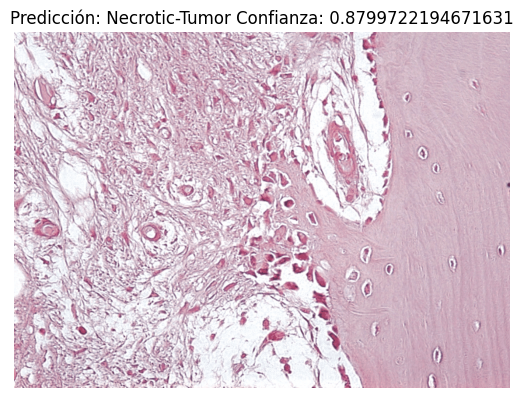

Predicción incorrecta. Se esperaba: Viable-Tumor


In [26]:
# Implementación de una predicción con YOLO para clasificación
from ultralytics import YOLO
import matplotlib.pyplot as plt
%matplotlib inline

# Cargar el modelo YOLO para clasificación
model = YOLO('../models/yolo/osteosarcoma2019/weights/best.pt')

# Cargar imagen de prueba
image_path = 'necrotic.png'

# Predicción
results = model(image_path)
predicted_class = results[0].names[results[0].probs.top1]
confidence = results[0].probs.top1conf

# Mostrar imagen con resultados
plt.imshow(plt.imread(image_path))
plt.title(f'Predicción: {predicted_class} Confianza: {confidence}')
plt.axis('off')
plt.show()

# Verificar 
ground_truth = 'Viable-Tumor'
if predicted_class == ground_truth:
    print('Predicción correcta!')
else:
    print(f'Predicción incorrecta. Se esperaba: {ground_truth}')


Ahora haremos un entrenamiento análogo con las demás redes de interés